# Question 3_a

Name = Maryam Karimi Jafari

Student ID = 99106617

# Setup

In [1]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

import keras
from imutils import paths
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
from IPython.display import Image
from keras.utils import to_categorical
from keras import regularizers


# Loading Data

creating a pandas dataframe from videos file path and their coresponding labels.

In [4]:
dataset_train_path = '/content/drive/MyDrive/SCR_HW3_Q4_LipReading/train'
dataset_test_path = '/content/drive/MyDrive/SCR_HW3_Q4_LipReading/test'

In [5]:
def create_dataframe_from_videos_name(folder_path):
    """
    Reads video file names from the given folder, extracts labels, and stores
    the file paths and labels in a pandas DataFrame.

    Args:
        folder_path (str): Path to the folder containing video files.

    Returns:
        pd.DataFrame: DataFrame with columns ['file_path', 'label'].
    """
    file_paths = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.mp4'):
            file_path = os.path.join(folder_path, filename)
            label = filename.split('w')[1].split('-')[0]
            file_paths.append(file_path)
            labels.append(label)

    data = {'file_path': file_paths, 'label': labels}
    df = pd.DataFrame(data)

    return df

In [6]:
train_df = create_dataframe_from_videos_name(dataset_train_path)
test_df = create_dataframe_from_videos_name(dataset_test_path)

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 160
Total videos for testing: 40


,file_path,label
125,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,3
14,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,5
109,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,4
66,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,3
41,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,1
38,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,2
69,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,4
92,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,5
74,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,5
118,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,2


# Define hyperparameters

In [7]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 200

MAX_SEQ_LENGTH = 30
# number of features is the CNN's output size
NUM_FEATURES = 2048

# Data preparation

In [8]:
# function for loading a video and making the frames
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    nf = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames), nf

using the CNN Inception model as feature extractor.

In [9]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()
feature_extractor.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

printing the labels and converting them to one hot encoding.

In [10]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["label"])
)
print(label_processor.get_vocabulary())

['1', '2', '3', '4', '5']


In [11]:
classes = to_categorical([int(i) for i in np.unique(train_df["label"])])
print(classes)

[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


## actually loading the data

In [12]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["file_path"].values.tolist()
    labels = df["label"].values
    labels = to_categorical(keras.ops.convert_to_numpy(label_processor(labels[..., None])))

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    max_nf = 0
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames, nf = load_video(os.path.join(root_dir, path))
        if nf > max_nf:
          max_nf = nf
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0,
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    print(f"Maximum number of frames: {nf}")
    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")
# we neead mask as input for using in hidden layer

Maximum number of frames: 20.0
Maximum number of frames: 26.0
Frame features in train set: (160, 30, 2048)
Frame masks in train set: (160, 30)


# building the model and training+evaluating

## training

In [13]:
def get_sequence_model():
    class_vocab = classes

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES), batch_size=BATCH_SIZE)
    mask_input = keras.Input((MAX_SEQ_LENGTH,), batch_size=BATCH_SIZE, dtype="bool")

    x = keras.layers.LSTM(8, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.LSTM(16, return_sequences=True)(x)
    x = keras.layers.LSTM(8, return_sequences=True)(x)
    x = keras.layers.LSTM(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(16, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model. summary()

    # changable learning rate
    sch = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,
                                                  decay_steps=100000,
                                                  decay_rate=0.9)
    rnn_model.compile(
        loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=sch), metrics=["accuracy"]
    )
    return rnn_model

In [22]:
# Utility for running experiments.
def run_experiment():
    # saving the model in my google drive
    filepath = "/content/drive/MyDrive/video_classifier_CNN_RNN/HW3_3_a_18.keras"
    # check point for saving the best model
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, monitor='val_accuracy', save_best_only=True, verbose=1
    )
    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.2,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    # evaluating the model
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history, sequence_model = run_experiment()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (64, 30, 2048)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (64, 30)               │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_16 (LSTM)            │ (64, 30, 8)            │         65,824 │ input_layer_10[0][0],  │
│                           │                        │                │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_17 (LSTM)            │ (64, 30, 16)           │          1,600 │ lstm_16[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_18 (LSTM)            │ (64, 30, 8)            │            800 │ lstm_17[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_19 (LSTM)            │ (64, 8)                │            544 │ lstm_18[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (64, 8)                │              0 │ lstm_19[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (64, 512)              │          4,608 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (64, 256)              │        131,328 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (64, 256)              │              0 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (64, 16)               │          4,112 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (64, 5)                │             85 │ dense_18[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 208,901 (816.02 KB)

 Trainable params: 208,901 (816.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.1562 - loss: 1.6111
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to /content/drive/MyDrive/video_classifier_CNN_RNN/HW3_3_a_18.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 592ms/step - accuracy: 0.1875 - loss: 1.6099 - val_accuracy: 0.1250 - val_loss: 1.6075
Epoch 2/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2344 - loss: 1.6071
Epoch 2: val_accuracy did not improve from 0.12500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2292 - loss: 1.6067 - val_accuracy: 0.1250 - val_loss: 1.6076
Epoch 3/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2344 - loss: 1.5978
Epoch 3: val_accuracy did not improve from 0.12500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2083 - loss: 1.6018 - val_accuracy: 0.1250 - val_loss: 1.6046
Epoch 4/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2188 - loss: 1.5920
Epoch 4: val_accuracy did not improve from 0.12500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/ste

result for evaluating => test accuracy = 80%

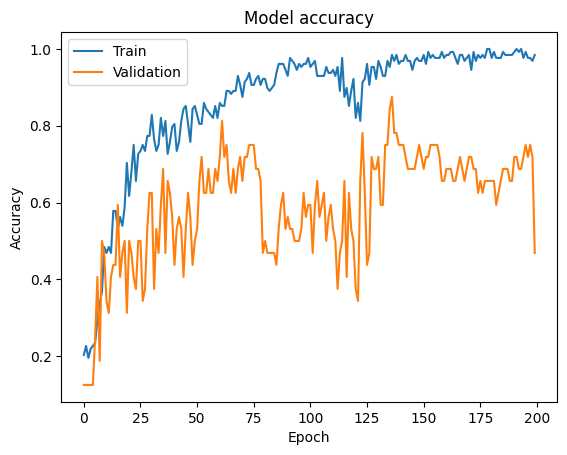

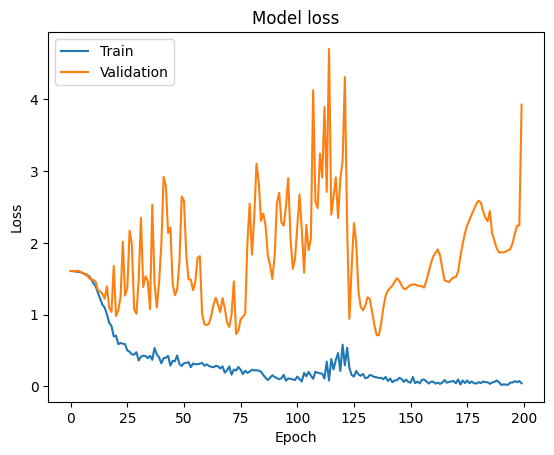

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## testing the result on a single random video

the result is 99.87 for class 1 which is right.

Test video path: /content/drive/MyDrive/SCR_HW3_Q4_LipReading/test/s9-w1-r4.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
  1: 99.87%
  4:  0.13%
  2:  0.00%
  3:  0.0

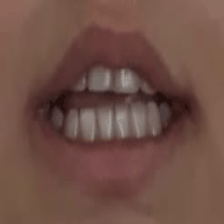

In [24]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(
        shape=(
            1,
            MAX_SEQ_LENGTH,
        ),
        dtype="bool",
    )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames,_ = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")


test_video = np.random.choice(test_df["file_path"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [33]:
sequence_model.save('/content/drive/MyDrive/video_classifier_CNN_RNN/HW3_3_a_18.h5')

## confusion matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


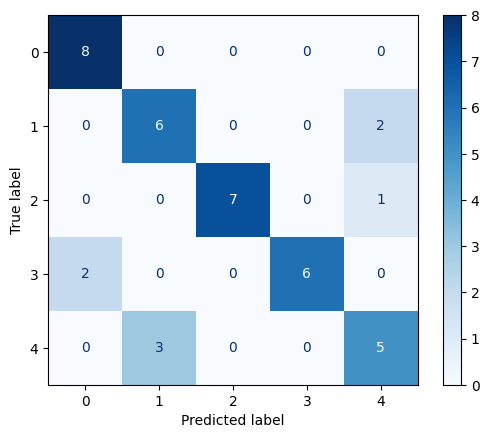

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test = test_labels
y_pred = sequence_model.predict(test_data)

labels = classes
y_pred_plot=np.argmax(y_pred, axis=1)
y_test_plot=np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_plot, y_pred_plot)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## model architecture

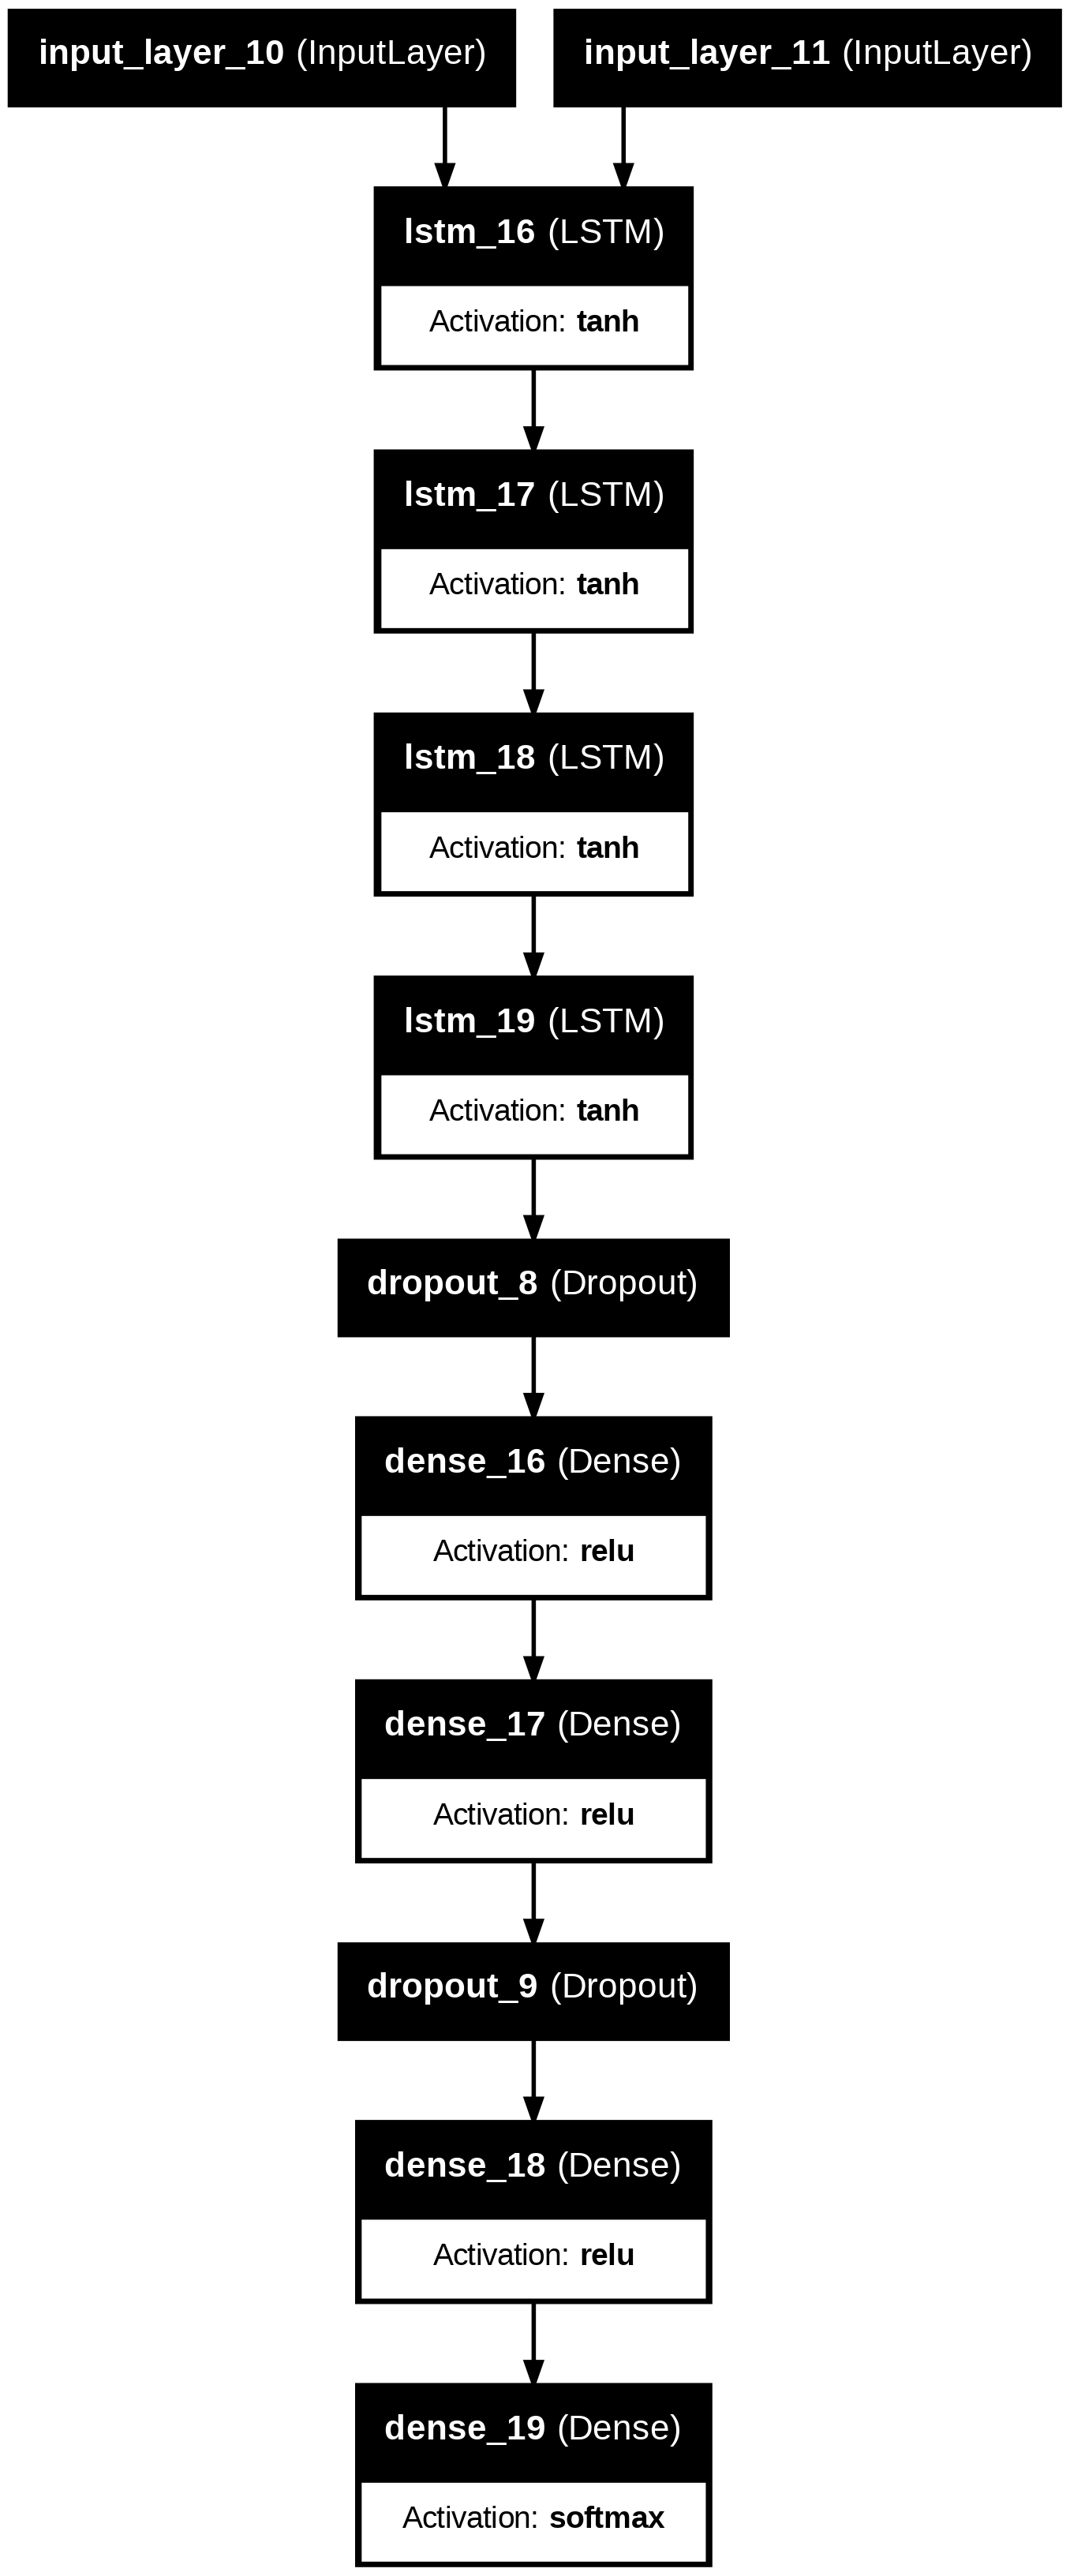

In [26]:
keras.utils.plot_model(sequence_model, show_layer_activations=True, show_layer_names=True)

about the model architecture: first of all i send my data to a pre-traineed CNN Inception model which its dense layers were omited, so the CNN extracted high features from each frame of the video. this part is for spartial features and the LSTM part is for temporal feature. the out put of CNN is a vector of size 2048, but you don't have to forget the mask data. the LSTM get this in order to understand which parts are padded. the sequential model contains of some LSTM layers and dense layers for final classification which you can see in the above picture too.



# loading and evaluating the best model

model link = https://drive.google.com/file/d/1-2VgIMveurb0nG6gkJygKffOkZm_iidc/view?usp=drive_link

best model name = HW3_3_a_18.h5

In [35]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/video_classifier_CNN_RNN/HW3_3_a_18.h5')

_, accuracy = model.evaluate([test_data[0], test_data[1]], test_labels)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8146 - loss: 1.1809 
Test accuracy: 80.0%


# references

https://www.tensorflow.org/tutorials/load_data/video#create_frames_from_each_video_file

https://www.tensorflow.org/tutorials/video/video_classification

https://keras.io/examples/vision/video_classification/

https://keras.io/api/applications/inceptionv3/

https://medium.com/@gcagrici/video-classification-with-deep-learning-3840b20b7949

https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5

https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/video_classification.ipynb#scrollTo=trmOK6x6ipyU

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/video.ipynb

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/action_recognition_with_tf_hub.ipynb

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/video_transformers.ipynb



